# Neural networks - Project 1
## Luis Filipe Menezes - RA: 164924

Este notebook foi feito como entrega para o 1º projeto da disciplina de Redes Neurais do Programa de Pós Gradução em Ciência da Computação (PPG-CC) da Univesidade Federal de São Paulo (UNIFESP).

Este projeto consiste em:

- Selecionar dois datasets (não triviais)

    - Um dataset para **classificação**

    - Um dataset para **regressão**

- Separar em treino/validação/teste

- Treinar modelos MLP para os dois problemas

- Considerar:

    - Diferentes topologias (>=5 topologias, variar número de camadas)
    - Usar o algoritmo original SGD (não usar algoritmos otimizados, e.g.ADAM)
    - Avaliar o impacto do uso do Momentum
    - Avaliar o impacto do uso da regularização (i.e. L2)

- Ilustrar graficamente a evolução do treinamento (treino/validação).

- Confeccionar um relatório (reprodutível) contendo os experimentos e resultados


# Predicting Crocodiles' conservation status

O primeiro problema a ser resolvido consiste em um problema de classificação utilizando um *dataset*
sobre conservação de espécies de crocodilos.

## Upload do dataset

Faremos o upload do *dataset* pela biblioteca **KaggleHub**.


In [1]:
import sys
import subprocess
import pkg_resources

try:
    pkg_resources.get_distribution('kagglehub')
    print("A biblioteca kagglehub já está instalada.")
except pkg_resources.DistributionNotFound:
    print("A biblioteca kagglehub não foi encontrada. Instalando...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
    print("kagglehub instalado com sucesso.")

/tmp/ipython-input-478603028.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


A biblioteca kagglehub já está instalada.


In [2]:
import kagglehub
import pandas as pd

# Download latest version
def download_and_load_dataset():
    path = kagglehub.dataset_download("zadafiyabhrami/global-crocodile-species-dataset") + "/crocodile_dataset.csv"
    df = pd.read_csv(path)
    return df, path

if __name__ == "__main__":
    df, path = download_and_load_dataset()
    print("Dataset preview: \n", df.info())

Using Colab cache for faster access to the 'global-crocodile-species-dataset' dataset.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observation ID        1000 non-null   int64  
 1   Common Name           1000 non-null   object 
 2   Scientific Name       1000 non-null   object 
 3   Family                1000 non-null   object 
 4   Genus                 1000 non-null   object 
 5   Observed Length (m)   1000 non-null   float64
 6   Observed Weight (kg)  1000 non-null   float64
 7   Age Class             1000 non-null   object 
 8   Sex                   1000 non-null   object 
 9   Date of Observation   1000 non-null   object 
 10  Country/Region        1000 non-null   object 
 11  Habitat Type          1000 non-null   object 
 12  Conservation Status   1000 non-null   object 
 13  Observer Name         1000 non-null  

## Preparação de dados

Existem 15 atributos no total, no entanto, nem todos podem ser utilizados para classificação, e.g. *Common Name*, *Notes* ou *Family*.

Alguns atributos não faz sentido entregar para o modelo, visto que a correlação teórica é alte (e.g. *Scientific Name*, se temos o nome científico da espécie, por equivalência também temos seu status de conservação.

In [48]:

cleaned_df = df.drop(columns=['Common Name', 'Notes', 'Family',
                              'Observer Name', 'Scientific Name',
                              'Date of Observation', 'Observation ID'])

# Célula para inspecionar as colunas categóricas
categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
print("Colunas categóricas restantes:\n", categorical_cols)
print("\nNúmero de valores únicos por coluna:")
print(cleaned_df[categorical_cols].nunique())

Colunas categóricas restantes:
 Index(['Genus', 'Age Class', 'Sex', 'Country/Region', 'Habitat Type',
       'Conservation Status'],
      dtype='object')

Número de valores únicos por coluna:
Genus                   3
Age Class               4
Sex                     3
Country/Region         47
Habitat Type           29
Conservation Status     5
dtype: int64


### Codificação e normalização de atributos
Das colunas categóricas restantes, vale a pena observar quais são apropriadas fazer **One-Hot Encoding** (1 de c), isto é, quais são **nominais** e quais são **ordinais**.

In [49]:

cols_nominal = ['Genus', 'Conservation Status', 'Country/Region', 'Habitat Type', 'Sex'] # Categorias nominais

# Aplica o One-Hot Encoding
encoded_df = pd.get_dummies(cleaned_df, columns=cols_nominal)

print("Dimensões do DataFrame após One-Hot Encoding:", encoded_df.shape)
display(encoded_df.head())

Dimensões do DataFrame após One-Hot Encoding: (1000, 90)


,Observed Length (m),Observed Weight (kg),Age Class,Genus_Crocodylus,Genus_Mecistops,Genus_Osteolaemus,Conservation Status_Critically Endangered,Conservation Status_Data Deficient,Conservation Status_Endangered,Conservation Status_Least Concern,...,Habitat Type_Rivers,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown
0,1.90,62.0,Adult,True,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
1,4.09,334.5,Adult,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1.08,118.2,Juvenile,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2.42,90.4,Adult,True,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
4,3.75,269.4,Adult,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True


In [74]:
cols_ordinal = ['Age Class', 'Conservation Status'] # Categorias ordinais

for col in cols_ordinal:
    print(df[col].value_counts())
    print("\n")

Age Class
Adult        510
Subadult     247
Juvenile     194
Hatchling     49
Name: count, dtype: int64


Conservation Status
Least Concern            384
Critically Endangered    275
Vulnerable               170
Data Deficient           115
Endangered                56
Name: count, dtype: int64




Note que o status de conservação, nossa classe a ser predita, possui uma categoria como *data deficient*, o que é cerca de $11,5$% do nosso conjunto de dados... Isso corresponde à duas especies que não temos dados sobre conservação.

Aqui nos encontramos com duas alternativas:
 - Retirar os dados faltantes.
 - Utilizar este como uma classe independente.

 Como o nosso conjunto de dados é pequeno e o modelo não será aplicado na industria, podemos utilizar estes como uma classe independente por si só.

In [51]:
df['Scientific Name'][cleaned_df['Conservation Status'] == 'Data Deficient'].unique()

array(['Osteolaemus osborni', 'Crocodylus raninus'], dtype=object)

In [52]:
age_class_mapper = {
    "Hatchling": 0,
    "Juvenile": 1,
    "Subadult": 2,
    "Adult": 3
}

encoded_df['Age Class'] = encoded_df['Age Class'].map(age_class_mapper)
display(encoded_df.head())

,Observed Length (m),Observed Weight (kg),Age Class,Genus_Crocodylus,Genus_Mecistops,Genus_Osteolaemus,Conservation Status_Critically Endangered,Conservation Status_Data Deficient,Conservation Status_Endangered,Conservation Status_Least Concern,...,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown,Age Class Encoded
0,1.90,62.0,Adult,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,3
1,4.09,334.5,Adult,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,3
2,1.08,118.2,Juvenile,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,1
3,2.42,90.4,Adult,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,3
4,3.75,269.4,Adult,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3


Para normalização, vamos observar as classes numéricas.
Para decidir se normalizaremos por distribuição ou utilizando minMaxScaler, precisamos analisar a presença de outliers nos dados numéricos

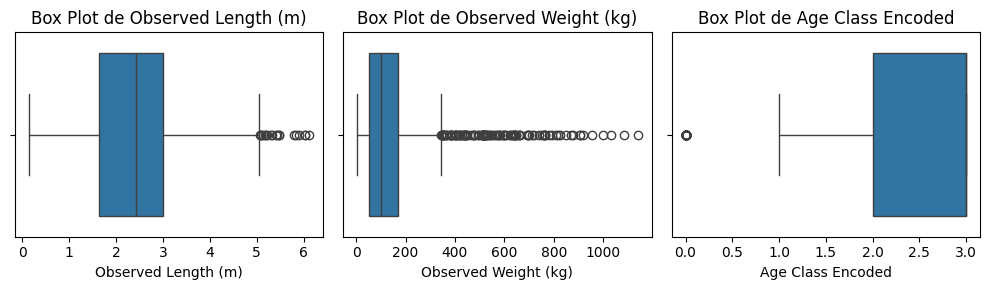

       Observed Length (m)  Observed Weight (kg)  Age Class Encoded
count          1000.000000           1000.000000        1000.000000
mean              2.415110            155.771900           2.218000
std               1.097542            175.186788           0.923758
min               0.140000              4.400000           0.000000
25%               1.637500             53.225000           2.000000
50%               2.430000            100.600000           3.000000
75%               3.010000            168.875000           3.000000
max               6.120000           1139.700000           3.000000


In [64]:
numeric_cols = encoded_df.select_dtypes(include=['int', 'float64']).columns

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(10, 3))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=encoded_df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot de {col}')

plt.tight_layout()
plt.show()
print(encoded_df[numeric_cols].describe())

Como a classe *Observed Weight* possui muitos outliers, vamos utilizar normalização por distribuição, utilizando o módulo *StandartScaler* do *scikitlearn*

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(encoded_df[numeric_cols])
encoded_df[numeric_cols] = scaler.transform(encoded_df[numeric_cols])
display(encoded_df[numeric_cols].describe())

,Observed Length (m),Observed Weight (kg),Age Class Encoded
count,1.000000e+03,1000.000000,1.000000e+03
mean,-1.953993e-17,0.000000,1.421085e-17
std,1.000500e+00,1.000500,1.000500e+00
min,-2.073951e+00,-0.864492,-2.402262e+00
25%,-7.088557e-01,-0.585650,-2.361106e-01
50%,1.357346e-02,-0.315089,8.469654e-01
75%,5.422914e-01,0.074832,8.469654e-01
max,3.377313e+00,5.619262,8.469654e-01


## Classificação

In [77]:
cols_to_predict = ['Conservation Status_Least Concern', 'Conservation Status_Critically Endangered', 'Conservation Status_Endangered', 'Conservation Status_Data Deficient',  'Conservation Status_Vulnerable']

Y = encoded_df[cols_to_predict]
X = encoded_df.drop(columns=cols_to_predict)
X.head()

,Observed Length (m),Observed Weight (kg),Age Class,Genus_Crocodylus,Genus_Mecistops,Genus_Osteolaemus,Country/Region_Australia,Country/Region_Belize,Country/Region_Cambodia,Country/Region_Cameroon,...,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown,Age Class Encoded
0,-0.469565,-0.535536,Adult,True,False,False,False,True,False,False,...,False,False,False,False,True,False,False,True,False,0.846965
1,1.526801,1.020725,Adult,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.846965
2,-1.217063,-0.214575,Juvenile,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,-1.319187
3,0.004458,-0.373342,Adult,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.846965
4,1.216862,0.648936,Adult,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0.846965
